In [ ]:
!pip install qiskit

In [20]:

#from qiskit.visualization import plot_bloch_multivector
#from qiskit.visualization import plot_histogram
#from qiskit.visualization import plot_state_qsphere
#from qiskit.extensions import Initialize # Import the Inititialize function
#from qiskit.circuit.library import QFT
#from qiskit.circuit import Gate
#from qiskit.quantum_info import Statevector, Operator
#from math import gcd
#from fractions import Fraction
#from qiskit.providers.aer import noise
#from qiskit.providers.ibmq import least_busy

from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter


from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

#IBMQ.save_account("c50f9f87a78d5ee318e203a4e4bb308f61fd5251660a7a11bf7188116fa3ccbb987511205f208a6eb999bbc7a4c01af81b11470c43d919858778f574edceb3c6")
from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import plotly
import plotly.express as px
from plotly.offline import plot

ibmqfactory.load_account:WARNING:2020-08-07 10:18:46,850: Credentials are already in use. The existing account in the session will be replaced.


# Qiskit Summer School Final Project: VQE



### Compute the ground state energy of LiH at various different interatomic distances
By changing the parameter `inter_dist`, you can use your VQE algorithm to calculate the ground state energy of LiH at various interatomic distances, and potentially produce a plot as you are seeing here. Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.
<img src="attachment:VQE_dist.png" width="600">

### How does your VQE algorithm perform in the presence of noise?
Trying importing the noise model and qubit coupling map of a real IBM quantum device into your simulation. You can use the imported noise model in your simulation by passing it into your quantum instance. You can also try enabling error mitigation in order to lower the effect of noise on your simulation results.

/usr/local/lib/python3.6/dist-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning:

This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).




 All energies have been calculated

 
 Mapping method: parity
Qubit operator Representation: paulis, qubits: 4, size: 100
Variation form: <qiskit.chemistry.components.variational_forms.uccsd.UCCSD object at 0x7fe4a54e8828>
Depth: 1
Init state: <qiskit.chemistry.components.initial_states.hartree_fock.HartreeFock object at 0x7fe4a7d3e940>
Optimizer (100 iterations): <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x7fe4ae78c208>


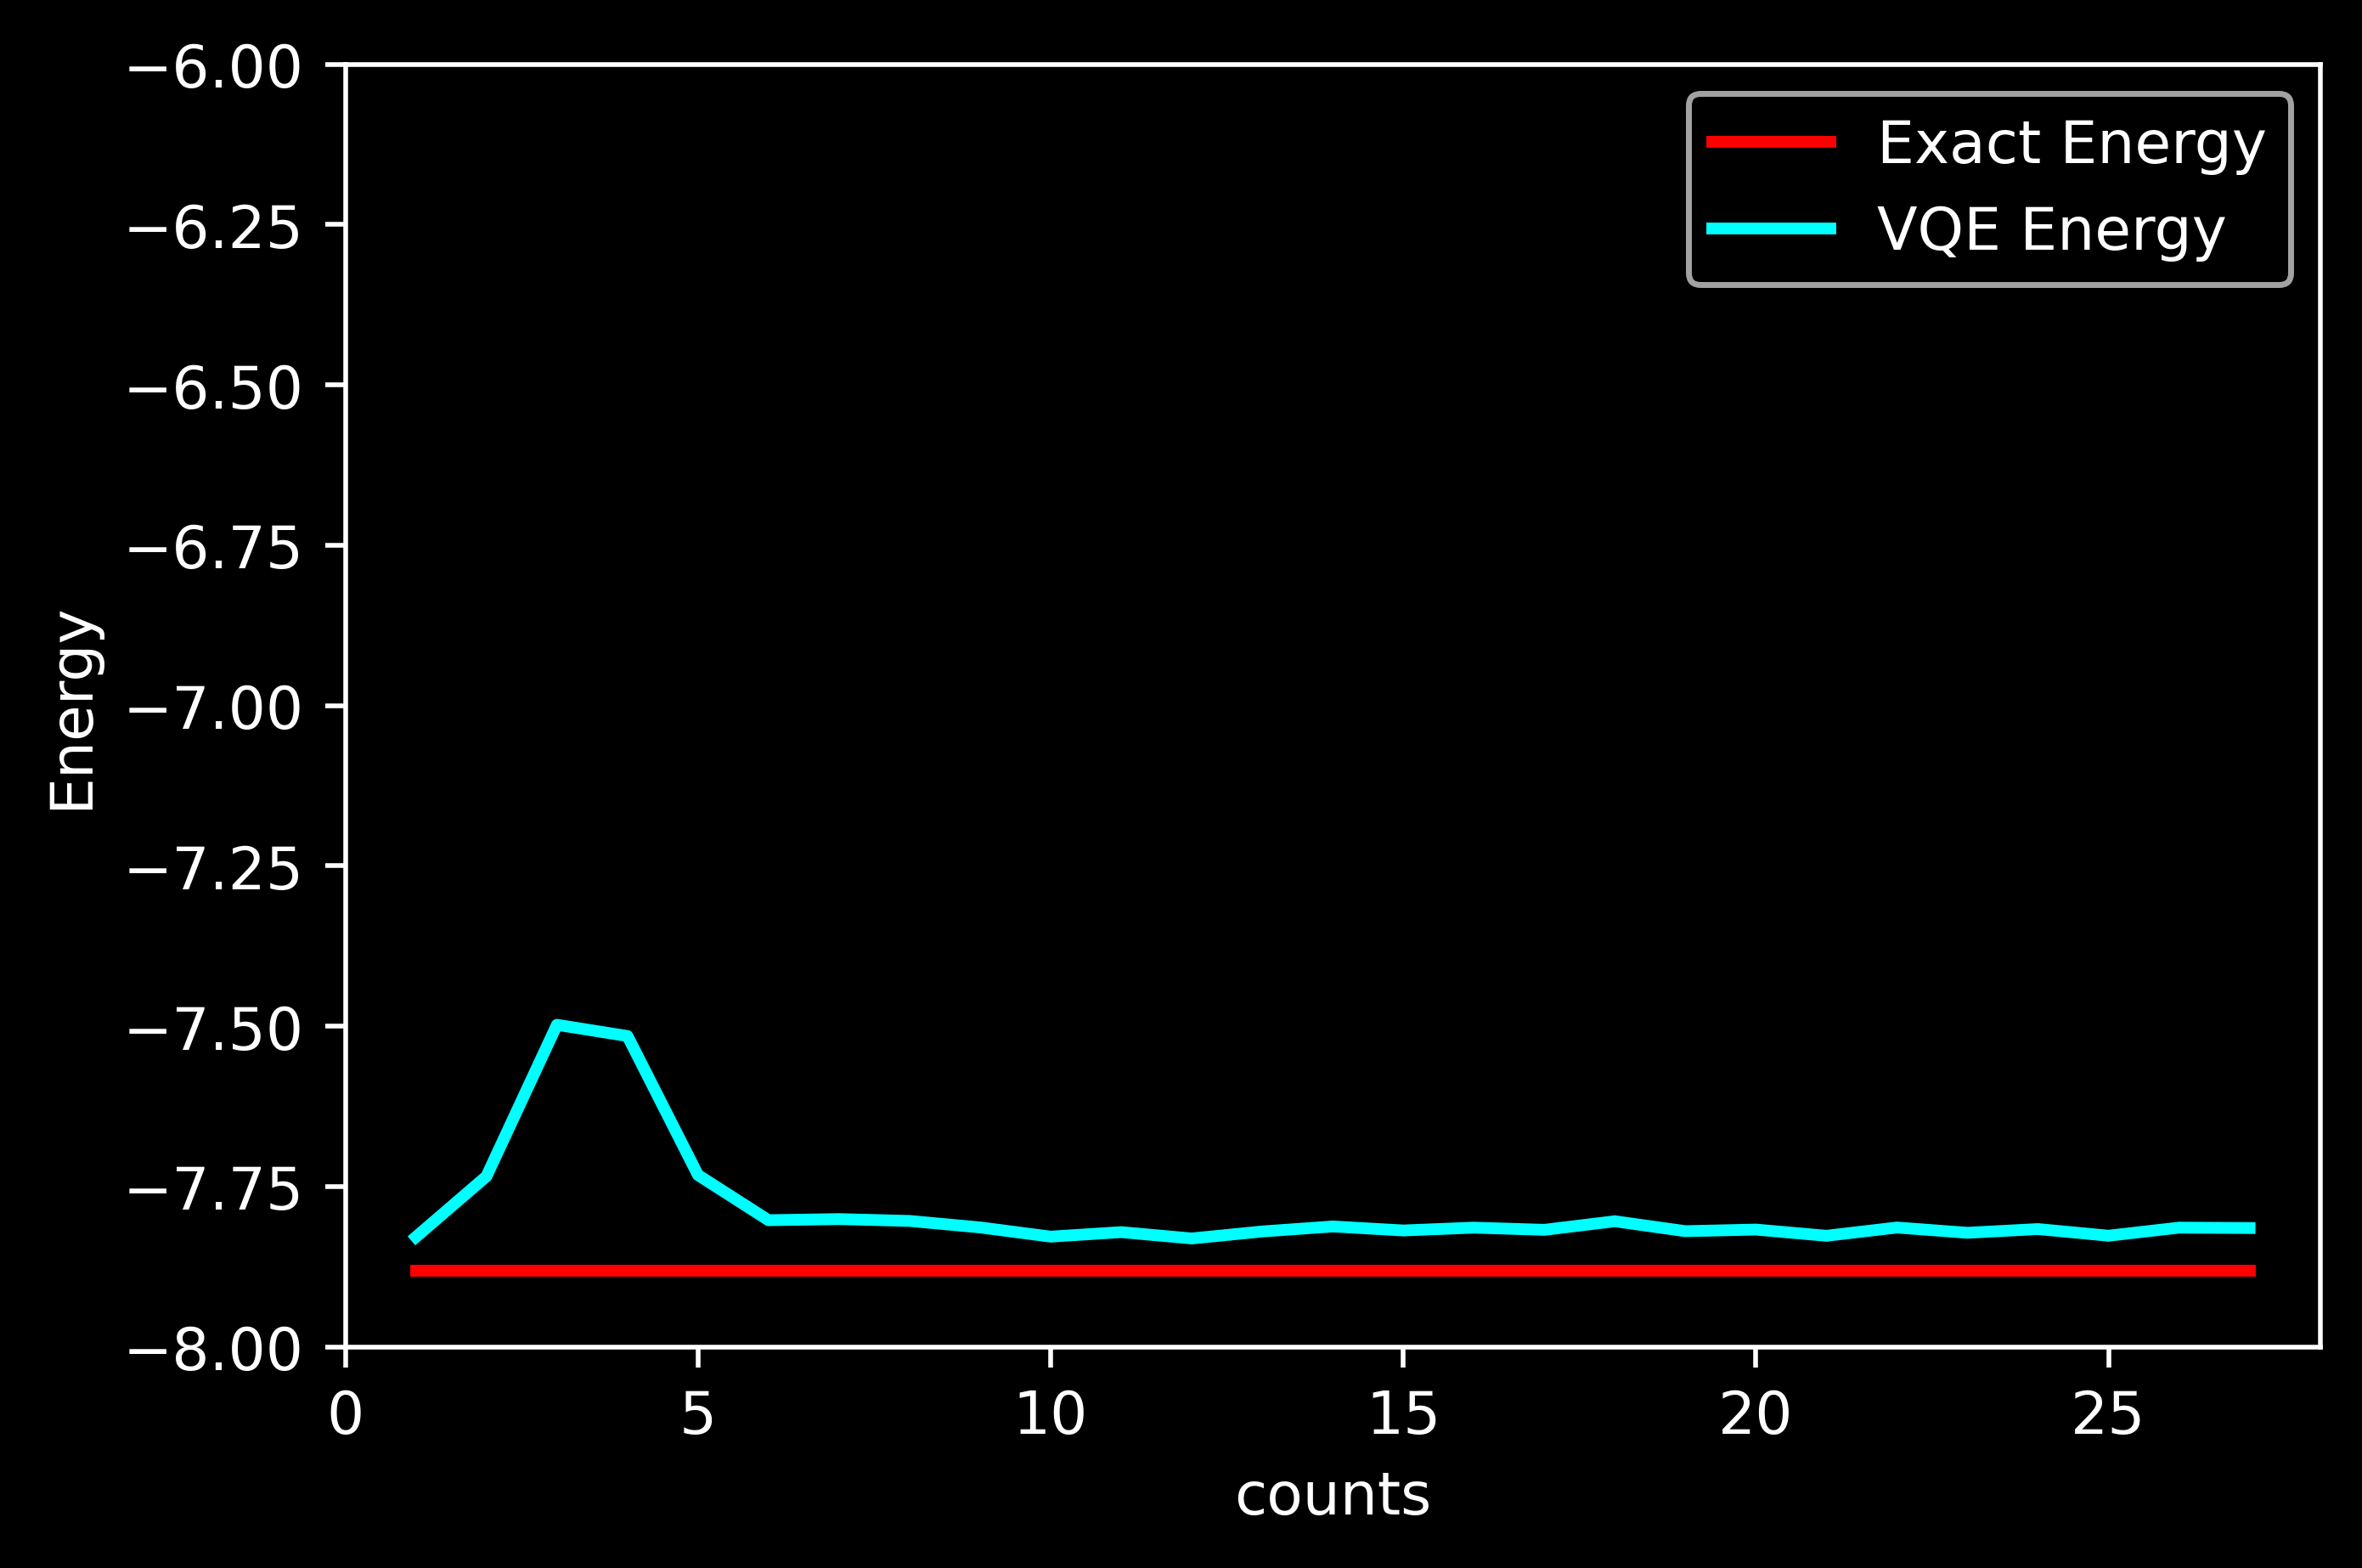

In [51]:


# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order

    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, nuclear_repulsion_energy, energy_shift




# Choose where to run/simulate our circuit
backend = Aer.get_backend('qasm_simulator')

#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

backend = QuantumInstance(backend=backend, shots=2000, noise_model=noise_model, coupling_map=coupling_map, measurement_error_mitigation_cls=CompleteMeasFitter, cals_matrix_refresh_period=30)

#Energy vs. distance
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []

#Energy vs. interation at dist=1.6
#distances = [1.6]
exact_energies = []
vqe_energies = []

counts = []
params = []
values = []
deviation = []



def run_VQE(map,initstate, depth, variation_form, optimizer):
  # Mapping type (parity, bravyi-kitaev, jordan-wigner)
  map_type = map 

  # This is only here in order to find qubitOp so that function works properly
  dist = 1.6
  qubitOp, num_spin_orbitals, num_particles, qubit_reduction, nuclear_repulsion_energy, energy_shift  = compute_LiH_qubitOp(map_type,dist)

  def store_intermediate_result(eval_count, parameters, mean, std): 
    counts.append(eval_count) 
    values.append(mean+ energy_shift+ nuclear_repulsion_energy) 
    params.append(parameters) 
    deviation.append(std)

  # Specify initial state
  if initstate == "HartreeFock":
    init_state = HartreeFock(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=map_type, two_qubit_reduction = qubit_reduction)
  elif initstate == "Zero":
    init_state = Zero(qubitOp.num_qubits)

  # Specify variation form
  if variation_form == 'UCCSD':
    var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping=map_type,excitation_type='s', method_singles='beta',initial_state=init_state, two_qubit_reduction=qubit_reduction, reps=depth)
  elif variation_form == 'RY':
    var_form = RY(num_qubits = qubitOp.num_qubits,depth = depth)
  elif variation_form == 'RYRZ':
    var_form = RYRZ(num_qubits = qubitOp.num_qubits, depth=depth)
  elif variation_form == 'SwapRZ':
    var_form = SwapRZ(num_qubits = qubitOp.num_qubits, depth=depth)
  
  # Choose the classical optimizer
  if optimizer == 'COBYLA':
    optimizer = COBYLA(maxiter=5)
  elif optimizer == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxiter=100)
  elif optimizer == 'SLSQP':
    optimizer = SLSQP(maxiter=100)
  elif optimizer == 'SPSA':
    optimizer = SPSA(max_trials=50)
  

  for dist in distances:
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, nuclear_repulsion_energy, energy_shift  = compute_LiH_qubitOp(map_type,dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + energy_shift+ nuclear_repulsion_energy )

    #for the convergence plot
    #vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    #for the distance plot
    vqe = VQE(qubitOp, var_form, optimizer)
    
    vqe_result = np.real(vqe.run(backend)['eigenvalue']+ energy_shift+ nuclear_repulsion_energy)

    vqe_energies.append(vqe_result)
    
    print("\n All energies have been calculated")
  
  #Printing info
  print("\n \n Mapping method:", map_type)
  print("Qubit operator",qubitOp)
  print("Variation form:",str(var_form))
  print("Depth:",depth)
  print("Init state:",str(init_state))
  print("Optimizer (100 iterations):",str(optimizer))

  #print(f"Number of spin orbitals: {num_spin_orbitals}")
  #print(f"Number of particles: {num_particles}")
  #print("Number of qubits:", qubitOp.num_qubits)
  #print(qubitOp.print_details())

  #Plotting energy vs. distance
  plt.figure(1,dpi=500)
  plt.style.use('dark_background')
  plt.plot(distances, exact_energies, label="Exact Energy", color='red', linewidth=2,markersize=8)
  plt.plot(distances, vqe_energies, label="VQE Energy", color='cyan',linewidth=2,markersize=8)
  plt.xlabel('Atomic distance (Angstrom)')
  plt.ylabel('Energy')
  plt.legend()
  plt.show()


  #Plotting energy vs. interation count
  #plt.figure(1,dpi=500)
  #plt.style.use('dark_background')
  #plt.plot(counts, np.ones(len(counts))*exact_energies[0][0], label="Exact Energy", color='red', linewidth=2,markersize=8)
  #plt.plot(counts, values, label="VQE Energy", color='cyan',linewidth=2,markersize=8)
  #plt.xlabel('counts')
  #plt.ylabel('Energy')
  #plt.axis([0,len(counts)+1,-8,-6])
  #plt.legend()
  #plt.show()



#Run VQE
run_VQE('parity','HartreeFock', 1, 'UCCSD', 'COBYLA')

#I get an error when running jordan/kitaev since these only reduce the Hamiltonian to 6 qubits, but imdb_essex only has 5!

# Now compare the results of different compositions of your VQE algorithm!